## Tasks and Classes


### Sub-task A :-
Sub-task A focus on Hate speech and Offensive language identification offered for English, German, Hindi. Sub-task A is coarse-grained binary classification in which participating system are required to classify tweets into two class, namely: Hate and Offensive (HOF) and Non- Hate and offensive (NOT).

* **(NOT) Non Hate-Offensive** - This post does not contain any Hate speech, offensive content.
* **(HOF) Hate and Offensive** - This post contains Hate, offensive, and profane content.

In our annotation, we label a post as HOF if it contains any form of non-acceptable language such as hate speech, aggression, profanity otherwise NOT.


### Sub-task B :-
Sub-task B is a fine-grained classification. Hate-speech and offensive posts from the sub-task A are further classified into three categories.

* **(HATE) Hate speech** :- Posts under this class contain Hate speech content.
* **(OFFN) Offenive** :- Posts under this class contain offensive content.
* **(PRFN) Profane** :- These posts contain profane words.


#### HATE SPEECH
Describing negative attributes or deficiencies to groups of individuals because they are members of a group (e.g. all poor people are stupid). Hateful comment toward groups because of race, political opinion, sexual orientation, gender, social status, health condition or similar.

#### OFFENSIVE
Posts which are degrading, dehumanizing,insulting an individual,threatening with violent acts are categorized into OFFENSIVE category.

#### PROFANITY
Unacceptable language in the absence of insults and abuse. This typically concerns the usage of swearwords (Scheiße, Fuck etc.) and cursing (Zur Hölle! Verdammt! etc.) are categorized into this category.
We expect most posts to be OTHER, some to be HATE and the other two categories to be less frequent. Dubious cases which are difficult to decide even for humans, should be left out.


### Sub-task C :-
Sub-task c will check the type of offense. Only posts labeled as HOF in sub-task A are included in sub-task C. The two categories in sub-task C are the following: 

* **Targeted Insult (TIN)**: Posts containing an insult/threat to an individual, group, or others.
* **Untargeted (UNT)**: Posts containing nontargeted profanity and swearing. Posts with general profanity are not targeted, but they contain non-acceptable language.
The multilingual HASOC Corpus will be sampled from Facebook and Twitter and distributed in tab separated format. Participants are allowed to use external resources and other datasets for this task. Dataset will be prepared in 3 languages (German, English and code-mixed hindi).

The size of Training data corpus is approximately 8000 posts for each language and Test data is approximately 1000 posts for the each language. Classification systems in all tasks will be evaluated using either macro-averaged F1-score or weighted F1-score.

In [12]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as sk_metrics
from sklearn.pipeline import Pipeline

In [2]:
DATA_PATHS_TRAIN = {
    "EN": "../data/raw/training_data/english_dataset.tsv",
    "DE": "../data/raw/training_data/german_dataset.tsv",
    "HI": "../data/raw/training_data/hindi_dataset.tsv"
}
DATA_PATHS_DEV = {
    "EN": "../data/raw/teaser_data/english_dataset.tsv",
    "DE": "../data/raw/teaser_data/german_dataset.tsv",
    "HI": "../data/raw/teaser_data/hindi_dataset.tsv"
}
DATA_COLUMNS = ["row_id", "text", "task_1", "task_2", "task_3"]
NUM_LANGUAGES = len(DATA_PATHS_TRAIN)

In [3]:
df = pd.read_csv(DATA_PATHS_TRAIN["EN"], sep="\t").fillna("NULL")
df.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


train
Index(['text_id', 'text', 'task_1', 'task_2', 'task_3'], dtype='object')
Index(['text_id', 'text', 'task_1', 'task_2'], dtype='object')
Index(['text_id', 'text', 'task_1', 'task_2', 'task_3'], dtype='object')
dev
Index(['text_id', 'text', 'task_1', 'task_2', 'task_3'], dtype='object')
Index(['text_id', 'text', 'task_1', 'task_2'], dtype='object')
Index(['text_id', 'text', 'task_1', 'task_2', 'task_3'], dtype='object')


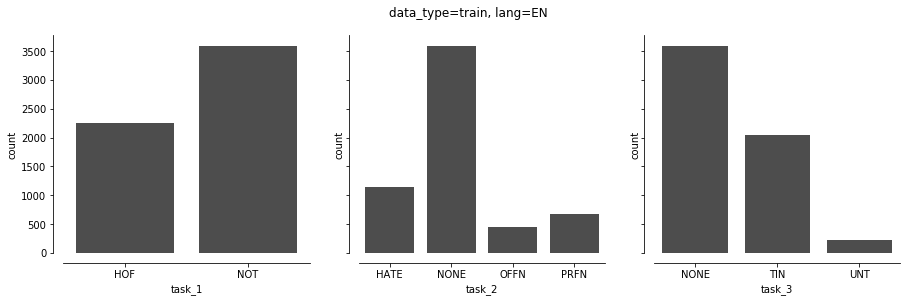

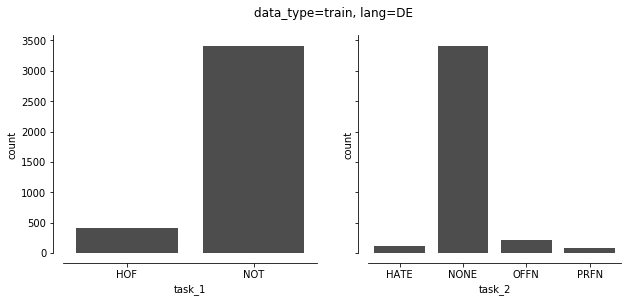

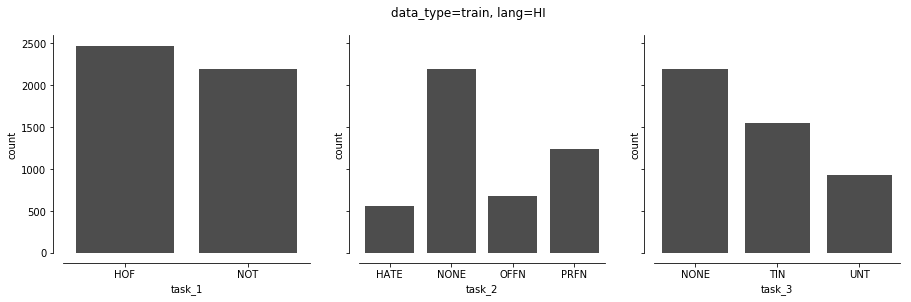

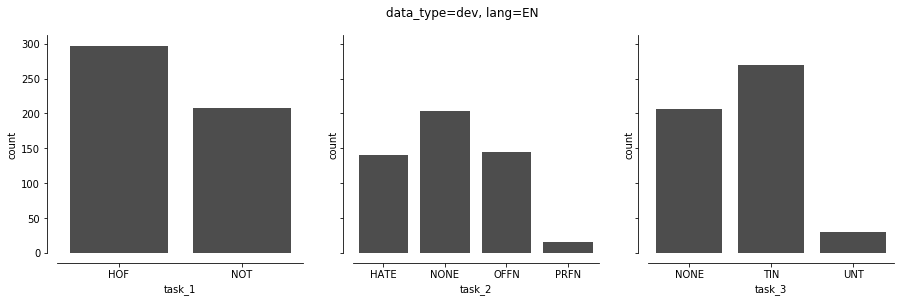

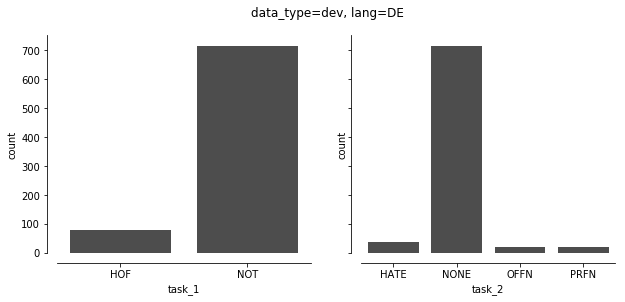

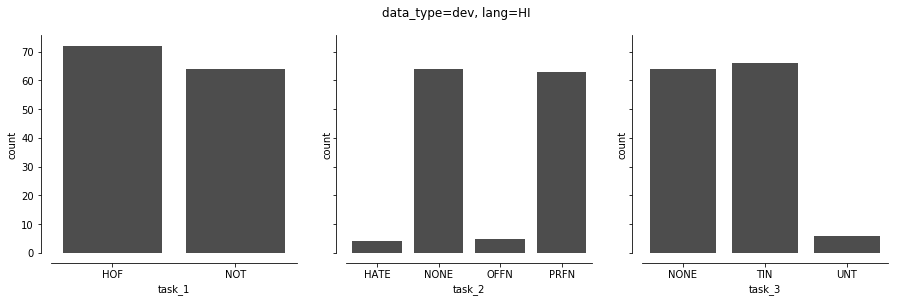

In [6]:
for data_type, DATA_PATHS in [("train", DATA_PATHS_TRAIN), ("dev", DATA_PATHS_DEV)]:
    print(data_type)
    for lang, path in DATA_PATHS.items():
        df = pd.read_csv(path, sep="\t").fillna("NULL")
        task_cols = df.filter(regex=r'task_*', axis=1).columns
        print(df.columns)
        n_cols = len(task_cols)
        fig, ax = plt.subplots(1, n_cols, sharey=True, figsize=(5*n_cols, 4))
        for axi, task in zip(ax.flatten(), task_cols):
            y = df[task].str.upper().replace("NULL", "NONE")
            sns.countplot(y, order=sorted(y.unique()), ax=axi, color="0.3")
        fig.suptitle(f"data_type={data_type}, lang={lang}")
        sns.despine(offset=10)

In [13]:
scorer = sk_metrics.make_scorer(sk_metrics.f1_score, average="macro")
for lang in ["EN", "DE", "HI"]:
    df_train=pd.read_csv(DATA_PATHS_TRAIN[lang], sep='\t').fillna("NULL")
    df_dev=pd.read_csv(DATA_PATHS_DEV[lang], sep='\t').fillna("NULL")
    X_train = df_train["text"]
    X_dev = df_dev["text"]
    print(f"{'='*20} {lang} {'='*20}")
    for task in ["task_1", "task_2", "task_3"]:
        if task not in df_train.columns:
            continue
        print(f"{'-'*20} {task} {'-'*20}")
        y_train = df_train[task].str.upper().replace("NULL", "NONE")
        y_dev = df_dev[task].str.upper().replace("NULL", "NONE")
        clf = Pipeline([ 
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf', LogisticRegressionCV(n_jobs=2, multi_class="multinomial", scoring=scorer)),
        ])
        idx = y_train != "NONE"
        clf.fit(X_train[idx], y_train[idx])
        y_pred = clf.predict(X_train)
        print(f"accuracy[train]\t= {sk_metrics.accuracy_score(y_train[idx], y_pred[idx]):.3f}")
        print(sk_metrics.classification_report(y_train[idx], y_pred[idx]))
        idx = y_dev != "NONE"
        y_pred = clf.predict(X_dev)
        print(f"accuracy[dev]\t= {sk_metrics.accuracy_score(y_dev[idx], y_pred[idx]):.3f}")
        print(sk_metrics.classification_report(y_dev[idx], y_pred[idx]))        

==================== EN ====================
-------------------- task_1 --------------------


F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


accuracy[train]	= 0.998
              precision    recall  f1-score   support

         HOF       1.00      1.00      1.00      2261
         NOT       1.00      1.00      1.00      3591

   micro avg       1.00      1.00      1.00      5852
   macro avg       1.00      1.00      1.00      5852
weighted avg       1.00      1.00      1.00      5852

accuracy[dev]	= 0.517
              precision    recall  f1-score   support

         HOF       0.65      0.38      0.48       297
         NOT       0.45      0.72      0.55       208

   micro avg       0.52      0.52      0.52       505
   macro avg       0.55      0.55      0.51       505
weighted avg       0.57      0.52      0.51       505

-------------------- task_2 --------------------


F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


accuracy[train]	= 1.000
              precision    recall  f1-score   support

        HATE       1.00      1.00      1.00      1143
        OFFN       1.00      1.00      1.00       451
        PRFN       1.00      1.00      1.00       667

   micro avg       1.00      1.00      1.00      2261
   macro avg       1.00      1.00      1.00      2261
weighted avg       1.00      1.00      1.00      2261

accuracy[dev]	= 0.474
              precision    recall  f1-score   support

        HATE       0.48      0.95      0.64       141
        OFFN       0.53      0.06      0.10       145
        PRFN       0.11      0.06      0.08        16

   micro avg       0.47      0.47      0.47       302
   macro avg       0.38      0.36      0.27       302
weighted avg       0.49      0.47      0.35       302

-------------------- task_3 --------------------


F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


accuracy[train]	= 1.000
              precision    recall  f1-score   support

         TIN       1.00      1.00      1.00      2041
         UNT       1.00      1.00      1.00       220

   micro avg       1.00      1.00      1.00      2261
   macro avg       1.00      1.00      1.00      2261
weighted avg       1.00      1.00      1.00      2261

accuracy[dev]	= 0.893
              precision    recall  f1-score   support

         TIN       0.90      0.99      0.94       269
         UNT       0.25      0.03      0.06        30

   micro avg       0.89      0.89      0.89       299
   macro avg       0.58      0.51      0.50       299
weighted avg       0.84      0.89      0.85       299

==================== DE ====================
-------------------- task_1 --------------------


F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


accuracy[train]	= 1.000
              precision    recall  f1-score   support

         HOF       1.00      1.00      1.00       407
         NOT       1.00      1.00      1.00      3412

   micro avg       1.00      1.00      1.00      3819
   macro avg       1.00      1.00      1.00      3819
weighted avg       1.00      1.00      1.00      3819

accuracy[dev]	= 0.919
              precision    recall  f1-score   support

         HOF       0.80      0.25      0.38        79
         NOT       0.92      0.99      0.96       715

   micro avg       0.92      0.92      0.92       794
   macro avg       0.86      0.62      0.67       794
weighted avg       0.91      0.92      0.90       794

-------------------- task_2 --------------------


F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


accuracy[train]	= 1.000
              precision    recall  f1-score   support

        HATE       1.00      1.00      1.00       111
        OFFN       1.00      1.00      1.00       210
        PRFN       1.00      1.00      1.00        86

   micro avg       1.00      1.00      1.00       407
   macro avg       1.00      1.00      1.00       407
weighted avg       1.00      1.00      1.00       407

accuracy[dev]	= 0.481
              precision    recall  f1-score   support

        HATE       0.75      0.32      0.44        38
        OFFN       0.37      0.81      0.51        21
        PRFN       0.53      0.45      0.49        20

   micro avg       0.48      0.48      0.48        79
   macro avg       0.55      0.53      0.48        79
weighted avg       0.59      0.48      0.47        79

==================== HI ====================
-------------------- task_1 --------------------


F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


accuracy[train]	= 0.921
              precision    recall  f1-score   support

         HOF       0.93      0.92      0.93      2469
         NOT       0.91      0.92      0.92      2196

   micro avg       0.92      0.92      0.92      4665
   macro avg       0.92      0.92      0.92      4665
weighted avg       0.92      0.92      0.92      4665

accuracy[dev]	= 0.676
              precision    recall  f1-score   support

         HOF       0.82      0.50      0.62        72
         NOT       0.61      0.88      0.72        64

   micro avg       0.68      0.68      0.68       136
   macro avg       0.71      0.69      0.67       136
weighted avg       0.72      0.68      0.67       136

-------------------- task_2 --------------------


F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


accuracy[train]	= 0.881
              precision    recall  f1-score   support

        HATE       0.88      0.78      0.83       556
        OFFN       0.86      0.82      0.84       676
        PRFN       0.89      0.96      0.92      1237

   micro avg       0.88      0.88      0.88      2469
   macro avg       0.88      0.85      0.86      2469
weighted avg       0.88      0.88      0.88      2469

accuracy[dev]	= 0.597
              precision    recall  f1-score   support

        HATE       0.14      0.50      0.22         4
        OFFN       0.13      0.40      0.20         5
        PRFN       0.91      0.62      0.74        63

   micro avg       0.60      0.60      0.60        72
   macro avg       0.39      0.51      0.39        72
weighted avg       0.81      0.60      0.67        72

-------------------- task_3 --------------------


F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


accuracy[train]	= 0.951
              precision    recall  f1-score   support

         TIN       0.95      0.97      0.96      1545
         UNT       0.95      0.92      0.93       924

   micro avg       0.95      0.95      0.95      2469
   macro avg       0.95      0.94      0.95      2469
weighted avg       0.95      0.95      0.95      2469

accuracy[dev]	= 0.542
              precision    recall  f1-score   support

         TIN       0.97      0.52      0.67        66
         UNT       0.14      0.83      0.23         6

   micro avg       0.54      0.54      0.54        72
   macro avg       0.55      0.67      0.45        72
weighted avg       0.90      0.54      0.64        72

